# Intent Recognition with BERT, Fine-Tuning the BERT model using Keras and TF


In [1]:
# Required to preprocess text for BERT inputs
!pip install -q tensorflow-text==2.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.3/464.3 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 83.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 19.5 MB/s eta 0:0

## Importing Necessary Libraries

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Mouting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
#Loading the Dataset
dataset = pd.read_csv('/content/drive/MyDrive/VA_Project/NLU Corpus.csv')

In [55]:
#Dataset first 5 rows
dataset.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [56]:
#Dropping Target Class from Dataframe and creating new Dataframe for target class
dataY= dataset.iloc[:,1:]
dataX= dataset.iloc[:,:1]

In [57]:
dataX.head()

,text
0,listen to westbam alumb allergic on google music
1,add step to me to the 50 clásicos playlist
2,i give this current textbook a rating value of...
3,play the song little robin redbreast
4,please add iris dement to my playlist this is ...


In [58]:

dataY.head()



,intent
0,PlayMusic
1,AddToPlaylist
2,RateBook
3,PlayMusic
4,AddToPlaylist


In [95]:
#Split the Dataset into Train Test and Validation set

from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(x_train, x_val, x_test)

                                                    text
1066            i would give bones of the earth 2 points
8598                     i give the next novel two stars
4219   please show me the films playing at loews cine...
4807   play the good sort of 1992 theme music by layz...
5346                        add vertexguy to beach vibes
...                                                  ...
3902                                play some bass music
8978   i want to add indestructible to my playlist a ...
9298                    i d like to watch mission to mir
12907  give the current essay a rating of zero out of...
2485   will it be colder in holladay saint kitts and ...

[10863 rows x 1 columns]                                                     text
12549  when is the sea of grass playing at the movie ...
1700   i need a table at a restaurant in ireland serv...
2092            show me the movie times for films nearby
14270                          give this album one stars
2384 

Making separate Train, Test and Val dataframe

In [69]:
traindf=pd.concat([x_train,y_train],axis=1)
traindf.shape

(10863, 2)

In [65]:
traindf.head()

,text,intent
8118,find the watcher at united paramount theatres,SearchScreeningEvent
13946,i want to book a steakhouse in vimy ridge,BookRestaurant
7745,book a taverna for a party of 10,BookRestaurant
3670,rate the nightmare fair five out of 6 stars,RateBook
11507,give me the weather forecast for zambia,GetWeather


In [70]:
testdf=pd.concat([x_test,y_test],axis=1)
testdf.shape

(1449, 2)

In [66]:
testdf.head()

,text,intent
79,put playa fly onto my 2010 decade playlist,AddToPlaylist
10661,play the música da série de filmes o hobbit al...,PlayMusic
8503,i would rate the door to december 3 points and...,RateBook
10856,what s the humidity now in nh,GetWeather
10050,play the song aura ii: the sacred rings,SearchCreativeWork


In [71]:
validdf= pd.concat([x_val,y_val],axis=1)
validdf.shape

(2172, 2)

In [72]:
validdf.head()


,text,intent
5695,when is the blood stain playing at the movie h...,SearchScreeningEvent
1429,what movies are playing in the neighborhood,SearchScreeningEvent
9035,is these girls at the cinema,SearchScreeningEvent
13026,book me a pizzeria that serves oreo for eight,BookRestaurant
3493,is it going to be windy faraway from the valle...,GetWeather


In [73]:
trainfeatures=traindf.copy()
trainlabels=trainfeatures.pop("intent")

In [74]:
trainlabels.shape

(10863,)

In [75]:
trainfeatures.head()

,text
8118,find the watcher at united paramount theatres
13946,i want to book a steakhouse in vimy ridge
7745,book a taverna for a party of 10
3670,rate the nightmare fair five out of 6 stars
11507,give me the weather forecast for zambia


In [76]:
trainfeatures=trainfeatures.values

In [77]:

from sklearn.preprocessing import LabelBinarizer
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

## One Hot Encoding

In [78]:
trainlabels.shape

(10863, 7)

In [79]:
testfeatures=testdf.copy()
testlabels=testfeatures.pop("intent")
validfeatures=validdf.copy()
validlabels=validfeatures.pop("intent")

testfeatures=testfeatures.values
validfeatures=validfeatures.values

testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

In [80]:
testlabels

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]])

## Loading the BERT model from TensorFlow *Hub*

In [81]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


## Loading the preprocessing model into a "hub.KerasLayer" to compose the fine-tuned model.

# Model Preprocessing

In [82]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [83]:
trainfeatures[0]

array(['find the watcher at united paramount theatres'], dtype=object)

In [84]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2424  1996  3422  2121  2012  2142 11734 13166   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model

Let's examine BERT's results first, before incorporating them into the model. Retrieving it from TF Hub and examining the results.

In [85]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [86]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.27431566 -0.20021673 -0.9995312  -0.7245887  -0.8540009  -0.4543669
 -0.9247425   0.2609942   0.21999009  0.37116405  0.64383346  0.00139069]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.3557944   0.23317114 -0.56539255 ...  0.20520487 -0.8666257
  -1.0396972 ]
 [-0.22631325  0.34646565  0.0664656  ...  0.14424586  1.2309422
  -0.19011733]
 [ 0.3151858  -0.01045319 -0.47635427 ... -0.2065301   0.44187477
   1.1587313 ]
 ...
 [ 0.36946857 -0.24454865 -0.2044566  ...  0.83020747  0.04091718
  -0.88593906]
 [ 0.25399274 -0.01311164 -0.19062048 ...  0.36129284 -0.6363698
  -0.5506367 ]
 [ 0.13654841 -0.32662648 -0.01727279 ...  0.5684525  -0.35744384
  -0.04793784]]


## Defining the model

In [87]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(7, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Checking that the model runs with the output of the preprocessing model.

In [88]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.10655458 0.03361043 0.19618252 0.08330998 0.14635241 0.08335934
  0.35063076]], shape=(1, 7), dtype=float32)


## Model Structure

In [89]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  41373185    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

# Training the model

In [90]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

##Loading the BERT model and training

In [91]:
epochs=5
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [92]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/5
340/340 [==============================] - 146s 394ms/step - loss: 0.3670 - categorical_accuracy: 0.8996 - val_loss: 0.0651 - val_categorical_accuracy: 0.9820
Epoch 2/5
340/340 [==============================] - 136s 400ms/step - loss: 0.0594 - categorical_accuracy: 0.9824 - val_loss: 0.0504 - val_categorical_accuracy: 0.9862
Epoch 3/5
340/340 [==============================] - 136s 401ms/step - loss: 0.0353 - categorical_accuracy: 0.9890 - val_loss: 0.0436 - val_categorical_accuracy: 0.9862
Epoch 4/5
340/340 [==============================] - 137s 404ms/step - loss: 0.0242 - categorical_accuracy: 0.9925 - val_loss: 0.0463 - val_categorical_accuracy: 0.9853
Epoch 5/5
340/340 [==============================] - 137s 404ms/step - loss: 0.0178 - categorical_accuracy: 0.9946 - val_loss: 0.0492 - val_categorical_accuracy: 0.9862


## Evaluating the Model

In [93]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

46/46 [==============================] - 7s 150ms/step - loss: 0.0569 - categorical_accuracy: 0.9848
Loss: 0.05691438913345337
Accuracy: 0.9848170876502991


## Plot the accuracy and loss 


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


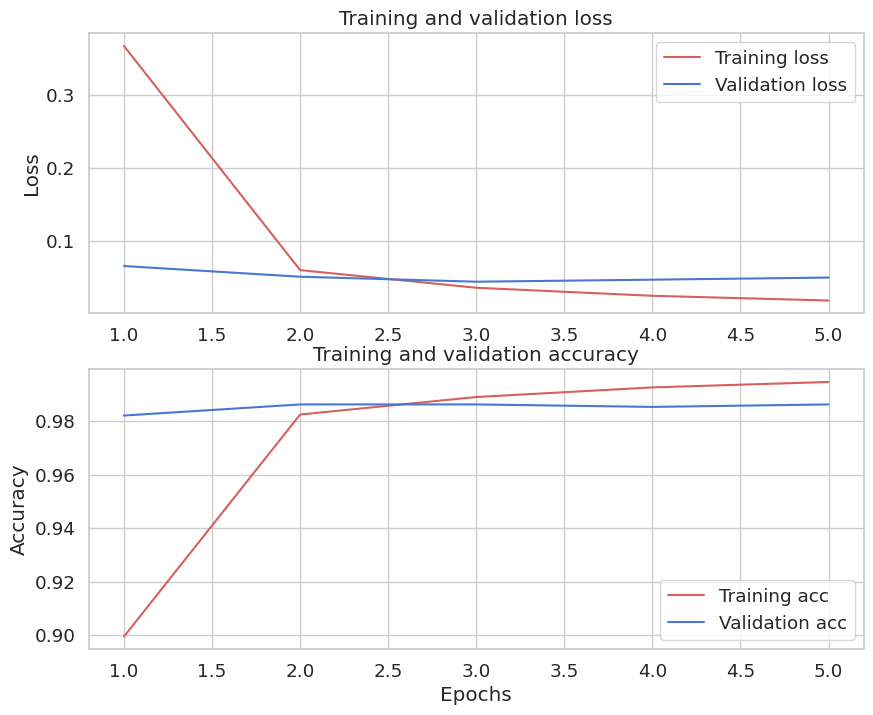

In [94]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')